In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

In [67]:
# Get data
data = pd.read_csv('../resources/data/data_fred_matlab.csv')

# Set date as index of df
data['sasdate'] = pd.to_datetime(data['sasdate'])
data.set_index('sasdate', inplace=True)

# Select only data from 1960-01-01 untill 2019-12-01
data = data.loc[(data.index >= '1960-01-01') & (data.index <= '2019-12-01')]

# Drop last column (unnamed)
data.drop(data.columns[-1], axis=1, inplace=True)

print("Data shape: ", data.shape)
data.head()


Data shape:  (720, 128)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1960-01-01,0.003193,0.004647,0.002784,0.016960,0.026606,0.025916,0.024100,0.029022,0.031235,0.103832,...,-0.001285,-0.004680,0.007797,-0.009705,-2.347448,-0.002451,0.004292,-0.011739,-0.013330,20.704305
1960-02-01,0.001145,0.000919,0.004327,0.014412,0.003696,-0.008937,-0.005684,-0.003439,-0.011455,-0.013858,...,0.000767,-0.004555,0.003853,-0.004750,-1.471062,-0.000001,0.008268,0.005388,-0.018942,16.198056
1960-03-01,0.001910,0.000918,0.014072,-0.028021,-0.001102,-0.009017,-0.003429,-0.001146,0.001154,-0.019963,...,-0.001025,-0.000020,0.030131,-0.004684,-3.569769,0.001738,0.003472,0.000951,0.003490,31.832723
1960-04-01,0.003426,0.003621,0.015382,0.009836,0.025903,-0.007961,0.002287,0.001146,0.006880,-0.001189,...,0.001531,-0.008949,-0.068074,0.000000,1.501161,-0.001048,0.008678,0.005452,0.024136,8.951634
1960-05-01,0.002403,0.002448,-0.020417,-0.031588,-0.015047,-0.001143,0.005691,0.006866,0.005698,0.009454,...,0.000504,0.008949,0.041620,0.000000,-1.552750,0.001035,-0.004827,-0.002067,0.003798,28.284980


In [68]:
# Inspecting data properties
data['INDPRO'].describe()

count    720.000000
mean       0.002095
std        0.007478
min       -0.044337
25%       -0.001667
50%        0.002385
75%        0.006443
max        0.030432
Name: INDPRO, dtype: float64

In sample PCA to compare to the original paper. Paper uses Jan 1960 to Dec 2019

(5, 128)


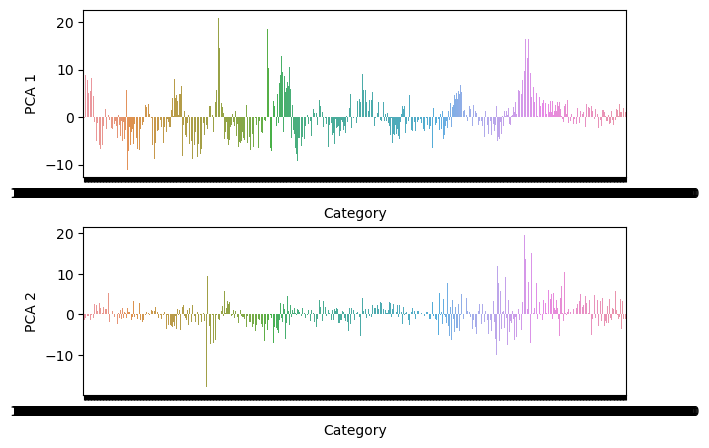

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create a PCA instance: pca
pca = PCA(n_components=5)

# Normalizer
normalizer = StandardScaler(with_mean=True, with_std=True)

data_pca = normalizer.fit_transform(data)

# Fit the PCA instance to the scaled samples
pca.fit(data_pca)

# Get the explained variances from pca
eigen_values = pca.explained_variance_ratio_

# Eigenvectors are the components
eigen_vectors = pca.components_

print(eigen_vectors.shape)
# Transform the scaled samples: pca_features
pca_features = pca.transform(data_pca)

plots = 2
fig, ax = plt.subplots(plots, 1, figsize=(7, 5))
plt.subplots_adjust(hspace=0.3)

for i in range(plots):
    sns.barplot(x = data.index, y=pca_features[:,i], ax=ax[i])
    ax[i].set_xlabel('Category')
    ax[i].set_ylabel('PCA {}'.format(i+1))


In [89]:
import numpy as np

def sPCAest(target, X, nfac):
    """
    This function performs sPCA (scaled principal component analysis) on the input data.
    It takes in three input variables, X, target, and nfac, and returns the sPCA factors in f.
    """

    T = len(target)
    if len(X) != T:
        print(f"X is of length {len(X)} and Y is of length {T}")
        raise ValueError('X and Y variables not of equal length')

    # Standardize X to Xs
    normalizer = StandardScaler(with_mean=True, with_std=True)
    Xs = normalizer.fit_transform(X)

    beta = np.empty((1, Xs.shape[1]))
    for j in range(Xs.shape[1]):
        xvar = np.column_stack((np.ones(T), Xs[:, j]))
        parm = np.linalg.lstsq(xvar, target, rcond=None)[0]
        beta[0, j] = parm[1]

    # One can choose to winsorize to remove extreme values
    # Removed here for simplicity

    scaleXs = np.empty((Xs.shape[0], Xs.shape[1]))
    for j in range(Xs.shape[1]):
        scaleXs[:, j] = Xs[:, j] * beta[0, j]

    # Perform PCA on the scaled Xs
    pca = PCA(n_components=nfac)
    pca.fit(scaleXs)
    f = pca.transform(scaleXs)
    eigen_values = pca.explained_variance_ratio_
    
    return f, eigen_values

In [93]:
h = 1
target = data['INDPRO'].shift(h).values
X, y = data.iloc[h:,:].values, target[h:]

f, eigens = sPCAest(y, X, 5)
print(eigens)


[0.41452175 0.09412941 0.06827742 0.04079882 0.03694243]


In [370]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE

def predict_pca(data, h_steps=1, response='CPIAUCSL', test_start='1985-01-01'):
    # Split into train and test sets with train ending at december 1984
    initial_train = data[:test_start]
    initial_test = data[test_start:]

    T_train = initial_train.shape[0]
    T_test = initial_test.shape[0]
    T = data.shape[0]

    # Split into X and y
    X = data
    y = data[response]

    # Shift y by h steps
    y = y.shift(h_steps)

    # Initialize the list of MSE's
    preds = []
    actuals = []


    # t is where the test set start
    for t in range(T_train, T):

        # Split into X and y, dropping first h rows from training data to account for the shift
        X_train, y_train = X[h_steps:t], y[h_steps:t]
        X_test, y_test = X[t:(t + h_steps)], y[t:(t + h_steps)]
        
        # Scale the features by the slope of the regression line
        X_train = scale_X(X_train, y_train)

        # Apply PCA to the features
        pca = PCA(n_components=5)
        pca.fit(X_train)
        
        # Transform the training and test sets
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test.values)

        # Fit the model to the training data
        model = LinearRegression()
        model.fit(X_train_pca, y_train)    

        # Make predictions 1 step ahead
        y_pred = model.predict(X_test_pca)

        # Compute the MSE
        preds.append(y_pred)
        actuals.append(y_test.values)


    return actuals, preds

def scale_X(X_train, y_train):
    X_train = X_train.copy()
    T = X_train.shape[0]

    # Standardize the data
    scaler = StandardScaler()
    X_train_standardized = scaler.fit_transform(X_train)

    slopes = []

    for i in range(X_train.shape[1]):
        # Seperate the predictor from the rest of the data
        X_predictor = X_train_standardized[:,i].reshape(-1, 1)

        # Fit the model
        lr = LinearRegression(fit_intercept=True)
        lr.fit(X_predictor, y_train)

        # Obtain the slope coefficient which is the beta
        slope = lr.coef_
        slopes.append(slope)

    scaler_demean = StandardScaler(with_mean=False, with_std=False)
    X_train_demeaned = scaler_demean.fit_transform(X_train)

    for i, slope in enumerate(slopes):
        X_train_demeaned[:,i] = X_train_demeaned[:,i] * slope

    return np.sqrt(T) * X_train_demeaned

def compute_R2(actuals, preds):
    SSR = []
    SST = []
    for i in range(len(actuals)):
        SSR.append(np.sum((actuals[i] - preds[i])**2))
        SST.append(np.sum((actuals[i] - np.mean(actuals[i]))**2))

    SSR = np.sum(SSR)
    SST = np.sum(SST)

    print("SSR: ", SSR, "SST: ", SST)
    R2 = 1 - SSR/SST
    return R2

In [369]:
actual_y, predicted_y = predict_pca(data, 1)

-inf


C:\Users\Vincent\AppData\Local\Temp\ipykernel_8508\2042118580.py:95: RuntimeWarning: divide by zero encountered in double_scalars
  R2 = 1 - np.sum(SSR)/np.sum(SST)


In [371]:
print(compute_R2(actual_y, predicted_y))

SSR:  1930.893431008673 SST:  0.0
-inf


C:\Users\Vincent\AppData\Local\Temp\ipykernel_8508\2607139705.py:99: RuntimeWarning: divide by zero encountered in double_scalars
  R2 = 1 - SSR/SST
